In [31]:
# importing libraries

import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import flatiron_stats as fs
import numpy as np

from statsmodels.stats.power import TTestIndPower, TTestPower
power_analysis = TTestIndPower()


In [4]:
#connection to SQL database

conn = sqlite3.connect('Northwind_small.sqlite')
cur  = conn.cursor()

## Does discount amount have a statistically significant effect on the quantity of a product in an order? If so, at what level(s) of discount?

In [5]:
order_detail = cur.execute('''

SELECT * FROM OrderDetail

;''').fetchall()

In [6]:
df = pd.DataFrame(order_detail)

df.columns = ['orderID/productID','orderID','productID',
                     'unit_price','quantity','discount']

df['total_price'] = df.apply(lambda row: row.unit_price * row.quantity, axis = 1) 


In [7]:
df.head()

,orderID/productID,orderID,productID,unit_price,quantity,discount,total_price
0,10248/11,10248,11,14.0,12,0.0,168.0
1,10248/42,10248,42,9.8,10,0.0,98.0
2,10248/72,10248,72,34.8,5,0.0,174.0
3,10249/14,10249,14,18.6,9,0.0,167.4
4,10249/51,10249,51,42.4,40,0.0,1696.0


In [51]:
# total sales for different discount rates
sales_for_discount = df.groupby('discount').sum()
sales_for_discount.sort_values(by='quantity',ascending=False, axis=0).head(6)

,orderID,productID,unit_price,quantity,total_price
discount,,,,,
0.00,14042897,54519,34467.91,28599,750698.61
0.05,1972417,7311,5697.32,5182,155386.71
0.15,1672996,6351,3607.22,4456,102948.44
0.10,1833523,7164,4354.68,4366,101665.71
0.20,1711705,6445,3787.81,4351,111476.38
0.25,1648801,5820,4345.02,4349,131918.09


In [37]:
df.discount.value_counts()

0.00    1317
0.05     185
0.10     173
0.20     161
0.15     157
0.25     154
0.03       3
0.02       2
0.01       1
0.04       1
0.06       1
Name: discount, dtype: int64

In [8]:
discount_0 = cur.execute('''
SELECT quantity FROM OrderDetail WHERE discount = 0.0
;''').fetchall()

discount_5 = cur.execute('''
SELECT quantity FROM OrderDetail WHERE discount = 0.05
;''').fetchall()

discount_10 = cur.execute('''
SELECT quantity FROM OrderDetail WHERE discount = 0.1
;''').fetchall()

discount_15 = cur.execute('''
SELECT quantity FROM OrderDetail WHERE discount = 0.15
;''').fetchall()

discount_20 = cur.execute('''
SELECT quantity FROM OrderDetail WHERE discount = 0.2
;''').fetchall()

discount_25 = cur.execute('''
SELECT quantity FROM OrderDetail WHERE discount = 0.25
;''').fetchall()

In [9]:
def tuple_to_list(item):
    results = []
    for t in item: 
        for x in t: 
            results.append(x) 
    return results

disc_0 = tuple_to_list(discount_0)
disc_5 = tuple_to_list(discount_5)
disc_10 = tuple_to_list(discount_10)
disc_15 = tuple_to_list(discount_15)
disc_20 = tuple_to_list(discount_20)
disc_25 = tuple_to_list(discount_25)

#now we have a list of quantities per product ordered for each discount category

## AB Testing 

In [29]:
#exploring data
def data_exploration(data):
    series = pd.Series(data)
    print('Mean: '+str(series.mean()))
    print('Std: '+str(series.std()))
    print('Len: '+str(len(series)))
    sns.distplot(data)
    
no_discount = np.array(disc_0)
some_discount = np.array(disc_5 + disc_10 + disc_15 + disc_20 + disc_25)

Mean: 27.35421686746988
Std: 20.720666776283
Len: 830


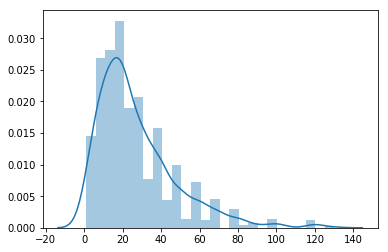

In [23]:
data_exploration(some_discount)

In [30]:
fs.p_value_welch_ttest(no_discount, some_discount, two_sided=False)

#according to this test, there is a signigficant difference between the two samples
#what is the effect size?

5.02563546334045e-11

In [33]:
def Cohen_d(group1, group2):
    diff = group1.mean() - group2.mean()
    n1, n2 = len(group1), len(group2)
    var1 = group1.var()
    var2 = group2.var()
    # Calculate the pooled threshold as shown earlier
    pooled_var = (n1 * var1 + n2 * var2) / (n1 + n2)
    # Calculate Cohen's d statistic
    d = diff / np.sqrt(pooled_var)
    return d


In [36]:
Cohen_d(some_discount,no_discount)

# Cohen's D value: 0.29
# If M1 is your experimental group, and M2 is your control group
# a positive effect size indicates that the effect increases your mean.
# Cohen’s d is the difference between two means, measured in standard deviations.
# This means that the discount has a small positive effect on the number of products ordered

0.2998530648320468

In [79]:
# total sales for different discount rates
sales_for_discount = df.groupby('discount').sum()
sales_for_discount

,orderID,productID,unit_price,quantity,total_price
discount,,,,,
0.00,14042897,54519,34467.91,28599,750698.61
0.05,1972417,7311,5697.32,5182,155386.71
0.10,1833523,7164,4354.68,4366,101665.71
0.15,1672996,6351,3607.22,4456,102948.44
0.20,1711705,6445,3787.81,4351,111476.38
0.25,1648801,5820,4345.02,4349,131918.09


,orderID/productID,orderID,productID,unit_price,quantity,discount,total_price
0,10248/11,10248,11,14.0,12,0.0,168.0
1,10248/42,10248,42,9.8,10,0.0,98.0
2,10248/72,10248,72,34.8,5,0.0,174.0
3,10249/14,10249,14,18.6,9,0.0,167.4
4,10249/51,10249,51,42.4,40,0.0,1696.0
